# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple, get_model_bhm, get_model_bhm_nc, get_model_logres, get_model_logres_nc

## 1. GDSCv2 analysis

### Load expression data

In [5]:
data_dir = os.path.abspath(os.path.join('..', 'Data'))
data_dir

'/Users/joewandy/Work/git/pyBasket/Data'

The data consists of 446 samples x 19957 transcripts

In [6]:
expr_file = os.path.join(data_dir, 'GDSCv2.exprsALL.tsv')
df = pd.read_csv(expr_file, sep='\t')
expr_df = df.drop(df.index[-25:]).transpose()
expr_df

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
KMH-2,2.644470,-9.965784,7.369643,2.521319,4.211213,-9.965784,1.926462,5.212597,3.104173,3.763338,...,-6.705062,-9.965784,-1.975997,-9.965784,2.052412,-9.965784,-0.561202,-0.021777,-2.262192,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


Each sample is assigned to one tissue

In [7]:
tissue_df = df.tail(25).astype(int).transpose()
tissue_df

,CNS/Brain,Bone,Prostate,Esophagus/Stomach,Bladder/Urinary Tract,Ovary/Fallopian Tube,Lymphoid,Kidney,Thyroid,Soft Tissue,...,Uterus,Pancreas,Breast,Cervix,Bowel,Peripheral Nervous System,Liver,Biliary Tract,Other,Ampulla of Vater
TGBC24TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
EGI-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
TGBC1TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ETK-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
SW1710,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
KMH-2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
HTC-C3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
IHH-4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
flat_list = tissue_df.reset_index().melt(id_vars='index', var_name='tissue', value_name='belongs_to_tissue')
flat_list = flat_list[flat_list['belongs_to_tissue'] != 0]

# set the index to the sample name
flat_list = flat_list.set_index('index')

# create the dictionary
sample_dict = flat_list['tissue'].to_dict()

In [9]:
tissues = np.array([sample_dict[s] for s in expr_df.index.values])
tissues[0:10]

array(['Biliary Tract', 'Biliary Tract', 'Biliary Tract', 'Biliary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bone'], dtype='<U25')

Do PCA and colour by basket (tissues)

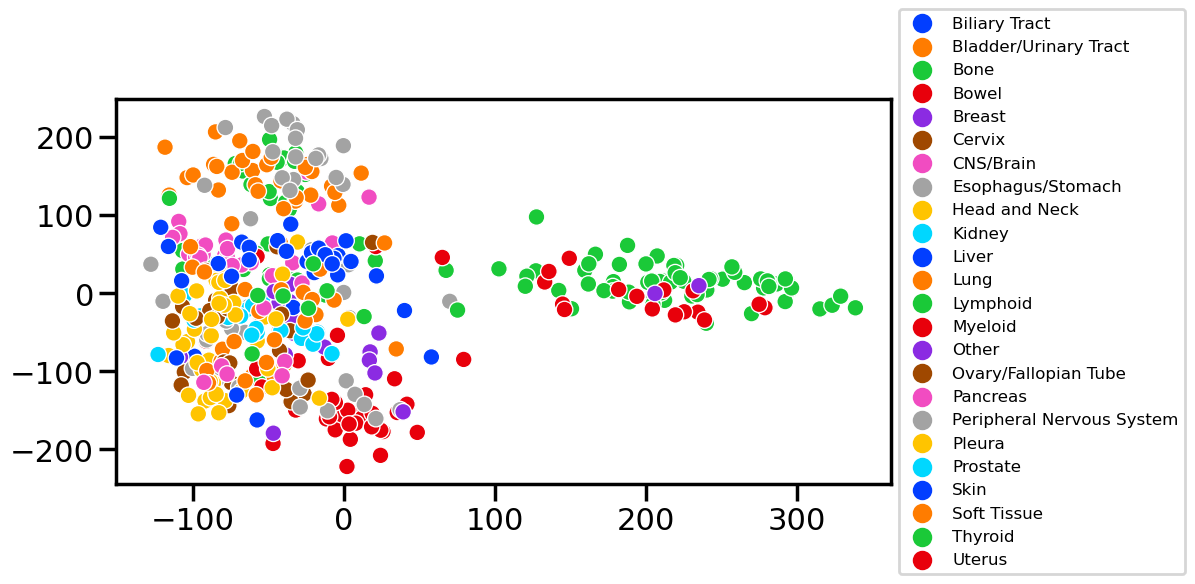

PCA explained variance [0.12949628 0.22238095 0.28729125 0.32075101 0.34293046 0.36347672
 0.38132787 0.39535598 0.40877654 0.4209827 ]


In [31]:
from sklearn.decomposition import PCA

# Create a PCA object with the number of components you want to keep
n_components = 10
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(expr_df)
pc1_values = pcs[:, 0]
pc2_values = pcs[:, 1]

sns.set_context('poster')
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1_values, y=pc2_values, hue=tissues, palette='bright')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)
plt.show()
print('PCA explained variance', pca.explained_variance_ratio_.cumsum())

### Load drug responses data

Each sample also has its corresponding drug response. There are 11 drugs.
Not sure why there are 1104 samples?

In [11]:
response_file = os.path.join(data_dir, 'GDSCv2.aacALL.tsv')
response_df = pd.read_csv(response_file, sep='\t').transpose()
response_df

,Bortezomib,Entinostat,Sirolimus,Docetaxel,Gemcitabine,Crizotinib,Lapatinib,Vorinostat,Erlotinib,Paclitaxel,Pictilisib
143B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22Rv1,0.184836,0.142503,0.304184,0.111977,0.596289,0.077036,0.048663,0.240865,0.069736,0.015539,0.254125
23132/87,0.228235,0.121580,0.208475,0.232821,0.407328,0.018921,0.172438,0.235145,0.124366,0.025982,0.431203
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
YH-13,0.174638,0.019992,0.157624,0.211467,0.359880,0.008977,0.069979,0.144077,0.108331,0.087400,0.349741
YKG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YMB-1-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YT,0.230123,NaN,0.212004,0.113564,0.666782,NaN,0.084477,0.235547,0.000000,0.000000,0.172903


In [12]:
response_df.loc['TGBC24TKB']

Bortezomib     0.046804
Entinostat     0.074151
Sirolimus      0.015096
Docetaxel      0.229496
Gemcitabine    0.410541
Crizotinib     0.000000
Lapatinib      0.239909
Vorinostat     0.181613
Erlotinib      0.128392
Paclitaxel     0.014104
Pictilisib     0.387379
Name: TGBC24TKB, dtype: float64

### Collect the samples and responses for 'Bortezomib'

In [13]:
samples = tissue_df.index.values
response_dict = response_df['Bortezomib'].to_dict()
responses = np.array([response_dict[s] for s in samples])
len(samples), len(responses), len(tissues)

(446, 446, 446)

In [14]:
df = pd.DataFrame({
    'tissues': tissues,
    'samples': samples,    
    'responses': responses
})
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.046804
1,Biliary Tract,EGI-1,0.172105
2,Biliary Tract,TGBC1TKB,0.180130
3,Biliary Tract,ETK-1,0.175669
4,Bladder/Urinary Tract,SW1710,0.235879
...,...,...,...
441,Thyroid,ASH-3,0.239005
442,Thyroid,KMH-2,NaN
443,Thyroid,HTC-C3,0.296591
444,Thyroid,IHH-4,0.099876


### Drop all the NaN responses

In [15]:
df = df.dropna(subset=['responses'])
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.046804
1,Biliary Tract,EGI-1,0.172105
2,Biliary Tract,TGBC1TKB,0.180130
3,Biliary Tract,ETK-1,0.175669
4,Bladder/Urinary Tract,SW1710,0.235879
...,...,...,...
440,Thyroid,WRO,0.079241
441,Thyroid,ASH-3,0.239005
443,Thyroid,HTC-C3,0.296591
444,Thyroid,IHH-4,0.099876


In [16]:
df['tissues'].unique()

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [17]:
df.groupby('tissues').count()

,samples,responses
tissues,,
Biliary Tract,4,4
Bladder/Urinary Tract,5,5
Bone,25,25
Bowel,28,28
Breast,11,11
CNS/Brain,14,14
Cervix,13,13
Esophagus/Stomach,19,19
Head and Neck,16,16


In [18]:
df['responses'].max(), df['responses'].min()

(0.441171871256905, 0.0066721853284744)

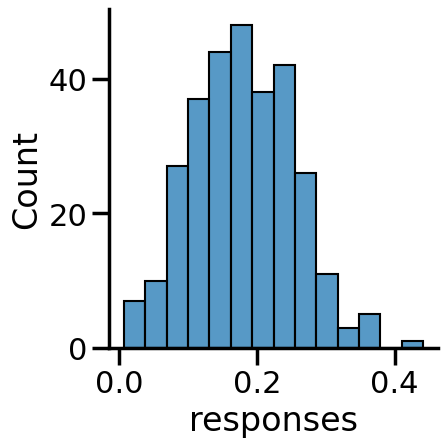

In [34]:
sns.displot(df['responses'])

In [19]:
basket_names = [
    'Lymphoid',
    'Bowel',
    'Bone',
    'Lung',
    'Esophagus/Stomach'
]

In [20]:
df_filtered = df[df['tissues'].isin(basket_names)].reset_index(drop=True)
df_filtered

,tissues,samples,responses
0,Bone,HuO9,0.166744
1,Bone,EW-13,0.021391
2,Bone,EW-16,0.111142
3,Bone,HuO-3N1,0.096453
4,Bone,ES8,0.201625
...,...,...,...
144,Lymphoid,P32/ISH,0.195581
145,Lymphoid,U266B1,0.238057
146,Lymphoid,ARH-77,0.299554
147,Lymphoid,RPMI-6666,0.239328


In [21]:
sample_list = df_filtered['samples'].tolist()
expr_df_filtered = expr_df[expr_df.index.isin(sample_list)]
expr_df_filtered.shape, expr_df.shape

((149, 19957), (446, 19957))

### Do PCA again on these samples

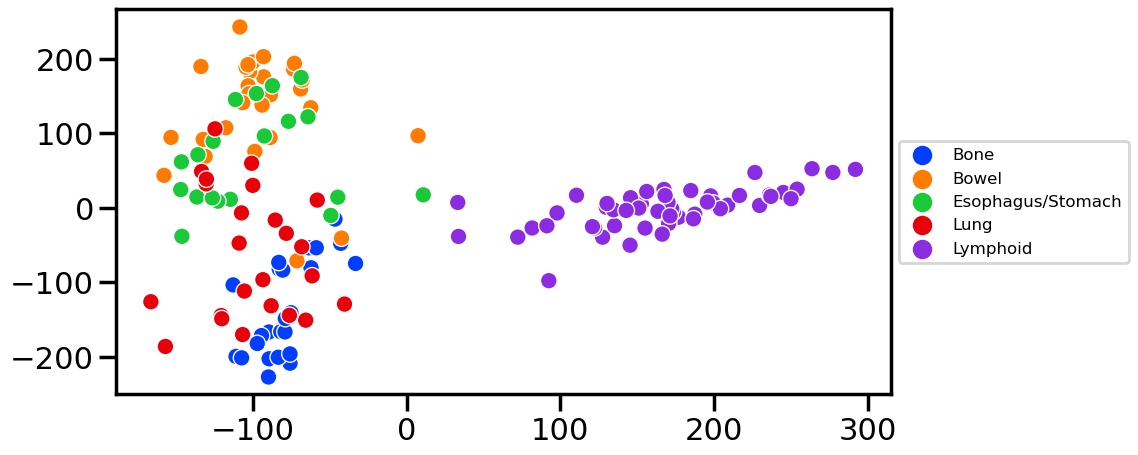

PCA explained variance [0.17798171 0.2893277  0.33408228 0.36955108 0.39926062 0.42392911
 0.44587426 0.46276147 0.47783613 0.49198685]


In [22]:
from sklearn.decomposition import PCA

# Create a PCA object with the number of components you want to keep
n_components = 10
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(expr_df_filtered)
pc1_values = pcs[:, 0]
pc2_values = pcs[:, 1]

sns.set_context('poster')
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1_values, y=pc2_values, hue=df_filtered['tissues'].values, palette='bright')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)
plt.show()
print('PCA explained variance', pca.explained_variance_ratio_.cumsum())

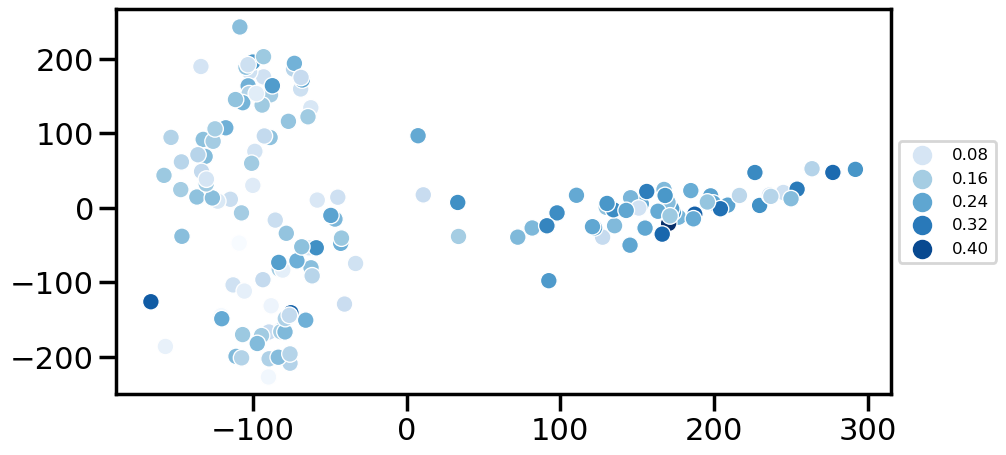

In [23]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1_values, y=pc2_values, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

### Try clustering

In [24]:
expr_df_filtered.shape

(149, 19957)

In [25]:
classes = df_filtered.set_index('samples')
classes

,tissues,responses
samples,,
HuO9,Bone,0.166744
EW-13,Bone,0.021391
EW-16,Bone,0.111142
HuO-3N1,Bone,0.096453
ES8,Bone,0.201625
...,...,...
P32/ISH,Lymphoid,0.195581
U266B1,Lymphoid,0.238057
ARH-77,Lymphoid,0.299554


In [26]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculate the distance matrix using the Euclidean distance
distance_matrix = linkage(expr_df_filtered.values, method='complete', metric='euclidean')

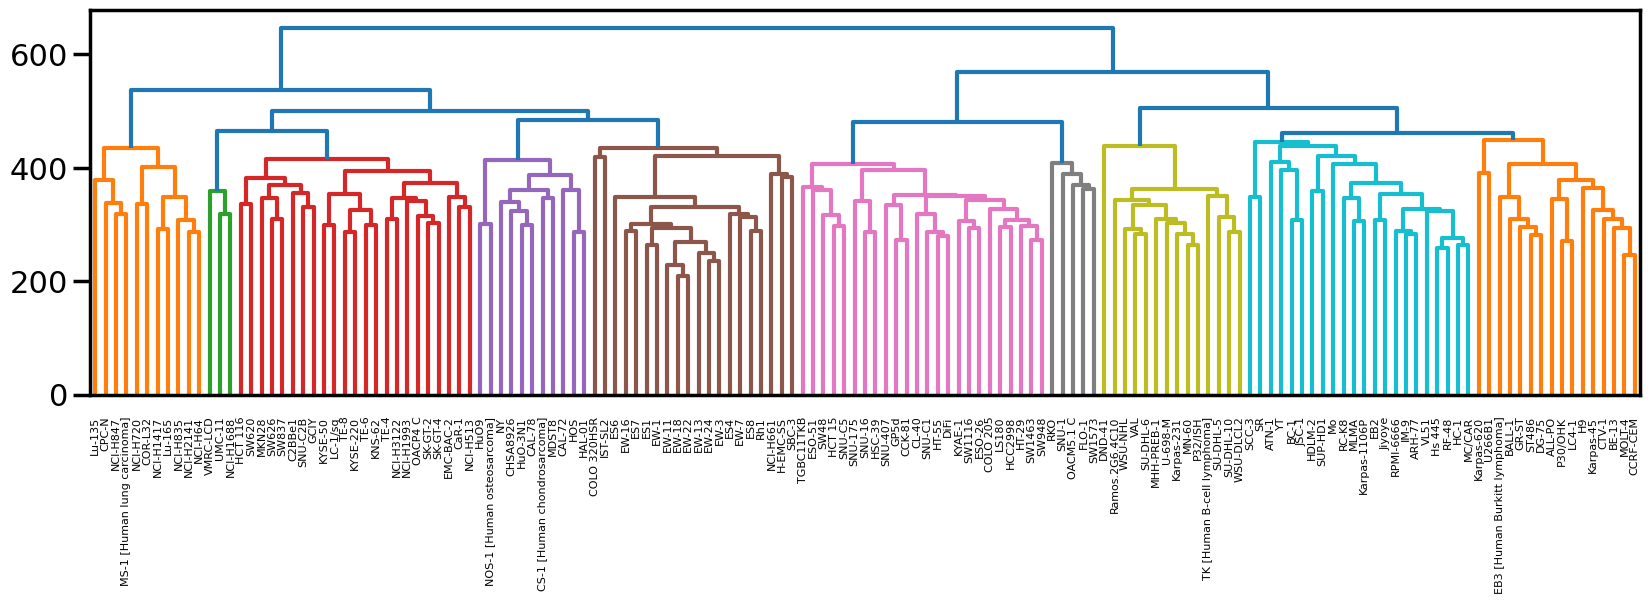

In [27]:
fig, ax = plt.subplots(figsize=(20, 5))
_ = dendrogram(distance_matrix, labels=expr_df_filtered.index, leaf_font_size=8)

In [28]:
palette = sns.color_palette("bright", len(classes["tissues"].unique()))
palette

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215)]

In [29]:
expr_df_filtered.index, classes.index

(Index(['HuO9', 'EW-13', 'EW-16', 'HuO-3N1', 'ES8', 'EW-24', 'EW-3', 'ES1',
        'Rh1', 'CHSA8926',
        ...
        'TK [Human B-cell lymphoma]', 'ATN-1', 'Jiyoye', 'H9', 'HAL-01',
        'P32/ISH', 'U266B1', 'ARH-77', 'RPMI-6666', 'SUP-HD1'],
       dtype='object', length=149),
 Index(['HuO9', 'EW-13', 'EW-16', 'HuO-3N1', 'ES8', 'EW-24', 'EW-3', 'ES1',
        'Rh1', 'CHSA8926',
        ...
        'TK [Human B-cell lymphoma]', 'ATN-1', 'Jiyoye', 'H9', 'HAL-01',
        'P32/ISH', 'U266B1', 'ARH-77', 'RPMI-6666', 'SUP-HD1'],
       dtype='object', name='samples', length=149))

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))
# dendrogram(distance_matrix, labels=expr_df_filtered.index, orientation='right',
#            color_threshold=0, above_threshold_color="gray",
#            leaf_font_size=10, link_color_func=lambda k: palette[classes.loc[k]['tissues']])

k-means

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(expr_df_filtered)

cluster_labels = kmeans.labels_
# df['cluster'] = cluster_labels

cluster_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

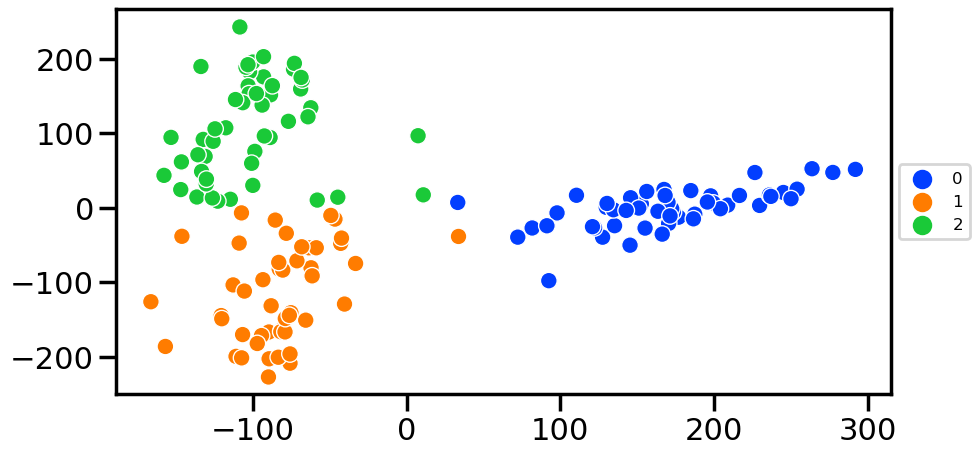

PCA explained variance [0.17798171 0.2893277  0.33408228 0.36955108 0.39926062 0.42392911
 0.44587426 0.46276153 0.47783633 0.49198721]


In [44]:
from sklearn.decomposition import PCA

# Create a PCA object with the number of components you want to keep
n_components = 10
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(expr_df_filtered)
pc1_values = pcs[:, 0]
pc2_values = pcs[:, 1]

sns.set_context('poster')
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1_values, y=pc2_values, hue=cluster_labels, palette='bright')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)
plt.show()
print('PCA explained variance', pca.explained_variance_ratio_.cumsum())